# Logbook

# jld2 -> netcdf

In [15]:
import h5py
import os
import json
import numpy as np
import xarray as xr
from pathlib import Path
from netCDF4 import Dataset


def list_files_dir(directory):
    dir_path = Path(directory)
    files = [f for f in dir_path.rglob('*') if f.is_file() and f.name.endswith('.jld2')]
    return files

def p(name, obj):
    print(name)
    if isinstance(obj, h5py.Dataset):
        print(obj[()])

def jld2_to_nc(jld2_file_path, nc_file_path, json_file_path):
    # ouverture des fichiers
    jl = h5py.File(jld2_file_path, 'r')
    if os.path.exists(nc_file_path):
        os.remove(nc_file_path)
    nc = Dataset(nc_file_path, 'w', format='NETCDF4')
    params = {}

    # time index/groups
    t_group = jl['timeseries']['t']
    i_t = list(t_group.keys())
    i_t = [int(i) for i in i_t]
    i_t.sort()
    i_t = [str(i) for i in i_t]
    
    # dimensions
    t = [t_group[i][()] for i in i_t]
    zw = jl['grid']['zᵃᵃᶠ'][3:-3]
    zr = jl['grid']['zᵃᵃᶜ'][3:-3]
    nc.createDimension('t', len(i_t))
    nc.createDimension('zw', len(zw))
    nc.createDimension('zr', len(zr))
    t_nc = nc.createVariable('t', np.float64, ('t',))
    zw_nc = nc.createVariable('zw', np.float64, ('zw',))
    zr_nc = nc.createVariable('zr', np.float64, ('zr',))
    t_nc[:] = t
    zw_nc[:] = zw
    zr_nc[:] = zr
    
    # variables
    Ri_nc = nc.createVariable('Ri', np.float64, ('t', 'zw'))
    T_nc = nc.createVariable('T', np.float64, ('t', 'zr'))
    TT_nc = nc.createVariable('TT', np.float64, ('t', 'zr'))
    b_nc = nc.createVariable('b', np.float64, ('t', 'zr'))
    bT_nc = nc.createVariable('bT', np.float64, ('t', 'zr'))
    e_nc = nc.createVariable('e', np.float64, ('t', 'zr'))
    p_nc = nc.createVariable('p', np.float64, ('t', 'zr'))
    u_nc = nc.createVariable('u', np.float64, ('t', 'zr'))
    uT_nc = nc.createVariable('uT', np.float64, ('t', 'zr'))
    ub_nc = nc.createVariable('ub', np.float64, ('t', 'zr'))
    uu_nc = nc.createVariable('uu', np.float64, ('t', 'zr'))
    uv_nc = nc.createVariable('uv', np.float64, ('t', 'zr'))
    v_nc = nc.createVariable('v', np.float64, ('t', 'zr'))
    vT_nc = nc.createVariable('vT', np.float64, ('t', 'zr'))
    vb_nc = nc.createVariable('vb', np.float64, ('t', 'zr'))
    vv_nc = nc.createVariable('vv', np.float64, ('t', 'zr'))
    wT_nc = nc.createVariable('wT', np.float64, ('t', 'zw'))
    wb_nc = nc.createVariable('wb', np.float64, ('t', 'zw'))
    wu_nc = nc.createVariable('wu', np.float64, ('t', 'zw'))
    wv_nc = nc.createVariable('wv', np.float64, ('t', 'zw'))
    ww_nc = nc.createVariable('ww', np.float64, ('t', 'zw'))
    KdzT_nc = nc.createVariable('KdzT', np.float64, ('t', 'zw'))
    mudzu_nc = nc.createVariable('mudzu', np.float64, ('t', 'zw'))
    mudzv_nc = nc.createVariable('mudzv', np.float64, ('t', 'zw'))
    mudzw_nc = nc.createVariable('mudzw', np.float64, ('t', 'zr'))
    for var, var_group in jl['timeseries'].items():
        match var:
            case 't':
                continue
            case 'κₑ_∂z_T':
                var = 'KdzT'
            case 'νₑ_∂z_u':
                var = 'mudzu'
            case 'νₑ_∂z_v':
                var = 'mudzv'
            case 'νₑ_∂z_w':
                var = 'mudzw'
        for i, ii in enumerate(i_t):
            ds = var_group[ii]
            arr = ds[3:-3, 0, 0]
            nc.variables[var][i, :] = arr
    
    # parameters
    params['Lz'] = jl['grid']['Lz'][()]
    params['Nz'] = jl['grid']['Nz'][()]
    params['constant_salinity'] = jl['buoyancy']['model']['constant_salinity'][()]
    params['gravitational_acceleration'] = jl['buoyancy']['model']['gravitational_acceleration'][()]
    params['thermal_expansion'] = jl['buoyancy']['model']['equation_of_state']['thermal_expansion'][()]
    params['haline_contraction'] = jl['buoyancy']['model']['equation_of_state']['haline_contraction'][()]
    params['Ckappa'] = jl['closure']['Cκ']['T'][()]
    params['Cmu'] = jl['closure']['Cν'][()]
    params['Coriolis'] = jl['coriolis']['f'][()]
    for name, ds in jl['parameters'].items():
        name = name.replace('²', '2')
        name = name.replace('θ', 'theta')
        if name in ['LESbrary_jl_commit_SHA1', 'name']:
            continue
        params[name] = ds[()]
    for k, v in params.items():
        if k == 'thermocline_type':
            params[k] = str(v)
        else:
            params[k] = float(v)

    # fermeture des fichiers
    jl.close()
    nc.close()
    jsonfile = open(json_file_path, 'w')
    json.dump(params, jsonfile, indent=4)
    jsonfile.close()
    

greg_path = os.path.join('..', 'obs', 'horizontally_averaged_LES_data')

greg_files_paths = list_files_dir(greg_path)

for jld2_file_path in greg_files_paths:
    # print(jld2_file_path)
    nc_file_path = jld2_file_path.with_suffix('.nc')
    json_file_path = jld2_file_path.with_suffix('.json')
    jld2_to_nc(jld2_file_path, nc_file_path, json_file_path)


In [100]:
ds = xr.open_dataset(nc_file_path)
ds['dzw'].values


array(9.96920997e+36)

In [1]:
import jax.numpy as jnp
print(jnp.array)
print(jnp.ndarray)

<function array at 0x123b0fe20>
<class 'jax.Array'>


# Minimal optimisation model


In [81]:
import equinox as eqx
import jax.numpy as jnp
from jax.scipy.optimize import minimize

def closure(u: jnp.array, clo_par: jnp.array):
    a, b = clo_par[0], clo_par[1]
    return a*u+b

class Stade(eqx.Module):
    nz: int
    nt: int
    u: jnp.array

    def __init__(self, nz: int=10, nt:int=10, init_val: float=0.):
        self.nz = nz
        self.nt = nt
        self.closure: str
        self.u = jnp.full(nz, init_val)
    
    def __str__(self):
        return self.u.__str__()

    def model_step(self, clo_par: jnp.array):
        
        return eqx.tree_at(lambda t: t.u, self, closure(self.u, clo_par))

    def model(self, clo_par: jnp.array):
        for _ in range(self.nt):
            self = self.model_step(clo_par)
        return self
    
    def J(self, target):
        return jnp.sum((self.u-target.u)**2)

def gen_min_fun():
    """ génère une fonction de minimisation"""

def min_fun(x, target):
    s = Stade()
    s = s.model(x)
    return s.J(target)


In [82]:
clo_par0 = jnp.array([1., 1.])
target = Stade(init_val=jnp.pi)

res = minimize(min_fun, clo_par0, args=(target,), method='BFGS')

print(res.x)
print(res)

[-0.652435   5.2648573]
OptimizeResults(x=Array([-0.652435 ,  5.2648573], dtype=float32), success=Array(False, dtype=bool), status=Array(3, dtype=int32, weak_type=True), fun=Array(5.684342e-13, dtype=float32), jac=Array([1.2319953e-05, 2.8453346e-06], dtype=float32), hess_inv=Array([[ 0.00462714, -0.01456416],
       [-0.01456416,  0.17343678]], dtype=float32), nfev=Array(32, dtype=int32, weak_type=True), njev=Array(32, dtype=int32, weak_type=True), nit=Array(9, dtype=int32, weak_type=True))


In [73]:
s = Stade()
print(s)
clo_par = jnp.array([1, 1])
s = s.model(clo_par)
print(s)

target = Stade(init_val=jnp.pi)

res = minimize(fun, jnp.array([2.]), method='BFGS')

print(res.x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
[0.]


# Testing Grids


                    loop 0
                    x [1.9999933 1.9999933]
                    grads [-0.807471 -0.807471]
                

                    loop 1
                    x [2.9756694 2.9756694]
                    grads [-0.56504536 -0.56504536]
                

                    loop 2
                    x [3.8910835 3.8910835]
                    grads [-0.322049 -0.322049]
                

                    loop 3
                    x [4.711759 4.711759]
                    grads [-0.13940392 -0.13940392]
                

                    loop 4
                    x [5.408696 5.408696]
                    grads [-0.00630141 -0.00630141]
                

                    loop 5
                    x [5.9579406 5.9579406]
                    grads [0.09798945 0.09798945]
                

                    loop 6
                    x [6.345199 6.345199]
                    grads [0.17953295 0.17953295]
                

                    loop 7
   

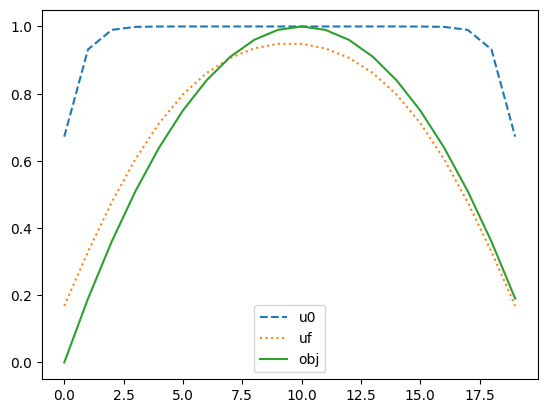

In [2]:
import sys
import os
os.chdir('../src')
from grid import Grid
import jax.numpy as jnp
from case import Case
from model import State, Experience
from fitter import Fitter, Fittable, CoefFitParams

import matplotlib.pyplot as plt
nz = 20

# experience
g = Grid.linear(nz, 200)
u0 = jnp.ones(nz)
state0 = State(g, u0)

nt = 50
case = Case()

# observation
x = jnp.arange(nz)
u_obs = -4*x*(x-nz)/(nz**2)
state_obs = State(g, u_obs)

# fitter
alpha_par = Fittable(True, min_bound=0., max_bound=10., init_val=1.)
beta_par = Fittable(False, fixed_val=1.)
coef_fit_params = CoefFitParams({'alpha': alpha_par, 'beta': beta_par})
nloop = 50
learning_rate = 1.
verbatim = True


f = Fitter(coef_fit_params, nloop, nt, g, state0, case, state_obs, learning_rate, verbatim)

clo_parf = f.fit_loop()

f.plot_res(clo_parf)


In [5]:
from jax import grad

def f(x):
    a = x['a']
    b = x['b']
    return a*b*b
dico = {'a': 3., 'b': 2.}
print(f(dico))
g = grad(f)
print(g(dico))

12.0
{'a': Array(4., dtype=float32, weak_type=True), 'b': Array(12., dtype=float32, weak_type=True)}
